In [ ]:
#Import required packages
import pandas as pd
import numpy as np
import librosa
import pathlib
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
import glob
from scipy import signal
import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/Shareddrives/CIS_519_Final_Project"

Mounted at /content/drive
/content/drive/Shareddrives/CIS_519_Final_Project


In [ ]:
#Read audio classification file and clean
audio_class_df = pd.read_csv("audioclassification_meta.csv")
c_names = audio_class_df.columns.tolist()
c_names = c_names[0].replace(" ", "_").split("\t")

audio_class_df[c_names] = audio_class_df['VoxCeleb1 ID\tVGGFace1 ID\tGender\tNationality\tSet'].\
                        str.split("\t", expand = True)
audio_class_df = audio_class_df[c_names]

#Set as dictionary
audio_class_dict = audio_class_df.set_index("VoxCeleb1_ID").T.to_dict('list')

#View data
audio_class_df.head()

,VoxCeleb1_ID,VGGFace1_ID,Gender,Nationality,Set
0,id10001,A.J._Buckley,m,Ireland,dev
1,id10002,A.R._Rahman,m,India,dev
2,id10003,Aamir_Khan,m,India,dev
3,id10004,Aaron_Tveit,m,USA,dev
4,id10005,Aaron_Yoo,m,USA,dev


In [ ]:
# Phoneme data needed to extract phonemes only
phoible_df = pd.read_csv("phoible.csv")

# Generate a mapping from nationality to language spoken
nationalities_to_language = {'Irish': 'English',
                             'India': 'Hindi', 
                             'USA': 'English (American)',
                             'Australia': 'English (Australian)',
                             'Canada': 'English', 
                             'UK': 'English (British)', 
                             'Norway': 'Norwegian',
                             'Italy': 'Italian',
                             'Sudan': 'Arabic',
                             'Mexico': 'Spanish',
                             'China': 'Standard Chinese; Mandarin',
                             'Switzerland': 'Swiss German',
                             'Guyana': 'English',
                             'Philippines':'Filipino',
                             'New Zealand': 'English (New Zealand)',
                             'Germany': 'German', 
                             'Portugal': 'Portuguese (European)',
                             'Netherlands': 'Dutch',
                             'Pakistan': 'Urdu',
                             'Croatia': 'Croatian',
                             'South Korea': 'Korean',
                             'Sweden': 'Swedish',
                             'Russia': 'Russian',
                             'Poland': 'Polish',
                             'Sri Lanka': 'Sinhalese', 
                             'Singapore': 'Mandarin Chinese',
                             'Chile': 'Spanish',
                             'Spain': 'Spanish',
                             'Israel':'Modern Hebrew',
                             'Brazil': 'Portuguese (Brazilian)',
                             'Trinidad and Tobago': 'English', 
                             'Denmark': 'Danish',
                             'Austria': 'German', 
                             'South Africa': 'English', 
                             'Iran': 'Farsi'} 

# Filter dataframe to only nationalities that will be encountered
phoible_df = phoible_df[phoible_df['LanguageName'].isin(list(nationalities_to_language.values()))]

# Find all languages spoken within VoxCeleb
all_languages = list(phoible_df['LanguageName'].unique())

# Define a mapping from language to phoneme 
# Key is language and value is a set of phonemes within that language
phonemes_per_lang = {}
for j in range(len(all_languages)):
    phonemes_per_lang[all_languages[j]] = {}
    phonemes_in_lang = phoible_df[phoible_df['LanguageName'] == all_languages[j]]['Phoneme'].unique()
    phonemes_per_lang[all_languages[j]] = set()
    for i in range(len(phonemes_in_lang)):
        phonemes_per_lang[all_languages[j]].add(phonemes_in_lang[i])

# Create a set of all the phonemes in English languages
eng_langs = ['English', 'English (American)','English (Australian)', \
             'English (British)', 'English (New Zealand)']
english_phonemes = set()
for lang in eng_langs:
    english_phonemes.update(phonemes_per_lang[lang])

# Define a mapping from English phonemes to allophones that may be present in tother languages
english_phonemes_to_allophones = {}
for phoneme in english_phonemes:
    english_phonemes_to_allophones[phoneme] = set(phoneme)                               
    for allophones in phoible_df[(phoible_df['Phoneme'] == phoneme) & (phoible_df['LanguageName'].isin(eng_langs))].Allophones:
        if pd.isnull(allophones) == False and allophones.isalnum():
            for allophone in allophones:
                english_phonemes_to_allophones[phoneme].add(allophone)

def get_key_english_phonemes_to_allophones(val):
    '''
    Function: Find English allophones of non-English phonemes
    Inputs: 
        - val: a phoneme
    Outputs:
        - key: the allophone that phoneme is known as in English, if applicable
    '''
    for key, value in english_phonemes_to_allophones.items():
        if val in value:
            return key

# Define phonemes that will be unseen in training as they are non-English and 
# remove them from a language's phoneme set, replaced by an unseen tag
for language in phonemes_per_lang:
    unseen_phonemes = set()
    for phoneme in phonemes_per_lang[language]:
        if phoneme not in english_phonemes:
            unseen_phonemes.add(phoneme) 
    for unseen_phoneme in unseen_phonemes:
        phonemes_per_lang[language].remove(unseen_phoneme)
        possible_allophone = get_key_english_phonemes_to_allophones(unseen_phoneme)
        if possible_allophone is not None:
            phonemes_per_lang[language].add(possible_allophone)
        else:
            phonemes_per_lang[language].add('unseen')

# Bypass languages to map directly from nationality to phoneme
nationalities_to_phonemes = {}
for nationality in nationalities_to_language.keys():
    nationalities_to_phonemes[nationality] = \
    phonemes_per_lang[nationalities_to_language[nationality]]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Path to audio npz files
speech_path = "/content/drive/Shareddrives/CIS_519_Final_Project/"
# Path to phoneme npz files
phoneme_path = "/content/drive/Shareddrives/CIS_519_Final_Project/"

In [ ]:
def pull_id_npz(file_name):
    '''
    Function: Load in files in npz format that are stored as dictionaries
    Inputs: 
        - file_name: string of file name containing path to file
    Outputs:
        - container_list: nested list containing values in the npz files
    '''
    container_list = []
    container = np.load(file_name,allow_pickle=True)
    container_list.append([container[key] for key in container])
    return container_list

In [ ]:
# Unpack npz files storing raw speech
def pull_speech_npz(speech_path, id):
    '''
    Function: Unpack npz files storing raw audio
    Inputs: 
        - speech_path: path to audio npz files
    Outputs:
        - nested list containing values in the npz files 
    '''
    for path, subdirs, files in os.walk(speech_path):
        if "phoneme" not in path:
            os.chdir(path)
        if (id+'.npz') in os.listdir():
            return pull_id_npz(id+'.npz')

In [ ]:
# Pull all the phoneme npz files associated with a given Voxceleb id
def pull_phoneme_npz(phoneme_path, id):
    '''
    Function: Unpack npz files storing phonemes
    Inputs: 
        - speech_path: path to phoneme npz files
    Outputs:
        - nested list containing values in the npz files 
    '''
    for path, subdirs, files in os.walk(phoneme_path):
        if "phoneme" in path:
            os.chdir(path)
        if (id+'.npz') in os.listdir():
            return pull_id_npz(id+'.npz')

In [ ]:
#from python_speech_features import fbank
# Function to calculate melspectrograms
def compute_melspec(data_to_ids_dict, sr = 16000):
    '''
    Function: Calculate melspectrogram from raw audio npz
    Inputs: 
        - data_to_ids_dict: dictionary of ids to raw audio extracted from npz file
    Outputs:
        - X_melspec: list of averaged melspectrograms per audio file
    '''
    X_melspec = []
    for key in data_to_ids_dict:
        if data_to_ids_dict[key] is not None:
            for data in data_to_ids_dict[key]:
                #Get melspectrogram features, give it time series data, take mean across 0 axis to get 1x128 vector
                melspec = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
                X_melspec.append(melspec)
    return X_melspec

In [ ]:
def extract_phonemes_for_training(phoneme_dict):
    '''
    Function: Extract phonemes per training instance 
    Inputs: 
        - phoneme_dict: dictionary of ids to phoneme sets extracted from npz file
    Outputs:
        - X: list of sets of extracted phonemes, 1 set per file 
    '''
    X = []
    for key in phoneme_dict.keys():
        for item in phoneme_dict[key][0]:
            X.append(item.item())
    return X

In [ ]:
def extract_nationalities(npz_to_speech_ids_dict, audio_class_dict):
    '''
    Function: Extract nationalities per training instance 
    Inputs: 
        - npz_to_speech_ids_dict: dictionary of ids to raw audio extracted from npz file
        - audio_class_dict: dictionary of id to nationality 
    Outputs:
        - X: list of sets of extracted nationalities, 1 nationality per file 
    '''
    y = []
    for key in npz_to_speech_ids_dict.keys():
        y_val = audio_class_dict[key][2]
        if npz_to_speech_ids_dict[key] is not None:
            for i in range(len(npz_to_speech_ids_dict[key][0])):
                y.append(y_val)
    return y

In [ ]:
# Define all nationalities as English or non English speaking
all_nationalities = list(audio_class_df['Nationality'].unique())
# Remove English speaking nationalities with only 1 speaker in the set 
all_nationalities.remove('South Africa')
all_nationalities.remove('Guyana')
all_nationalities.remove('Trinidad and Tobago')
all_nationalities.remove('Germany') # difficulty generating npz files here


eng_nationalities =  ['USA', 'UK', 'Australia', 'Canada', 'New Zealand', 'Ireland']
non_eng_nationalities = [nationality for nationality in all_nationalities if nationality not in eng_nationalities]

In [ ]:
#Pre-Processing: Filtering

#Sampling rate of audio data
fs = 16000

def butter_lowpass(data, lowcut = 5000, fs=16000, order = 4):
    '''
    Function: Apply lowpass butterworth filter
    Inputs:
        - data: numpy array of wave data
        - lowcut: cutoff frequency, default set to 5000 Hz 
        - fs: sampling rate, default set to 16000 Hz (based on VoxCeleb data)
        - order: filter order, default set to 4. Larger order = sharper cutoff
    Output:
        - y: numpy array, filtered version of wave data
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    y = signal.lfilter(b, a, data)
    return y

def butter_highpass(data, highcut = 75, fs=16000, order = 4):
    '''
    Function: Apply lowpass butterworth filter
    Inputs:
        - data: numpy array of wave data
        - highcut: cutoff frequency, default set to 75 Hz (below this is mostly noise)
        - fs: sampling rate, default set to 16000 Hz (based on VoxCeleb data)
        - order: filter order, default set to 4. Larger order = sharper cutoff
    Output:
        - y: numpy array, filtered version of wave data
    '''
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    y = signal.lfilter(b, a, data)
    return y

def filter_signals(all_npz_dict):
    '''
    Function: Filter all signals in npz dictionaries with lowpass and highpass filters
    Inputs: 
        - all_npz_dict: dictionary keyed by folders, contains lists of numpy arrays representing wave files
    Outputs:
        - filtered_npz: dictionary keyed by folders, contains list of numpy arrays representing filtered wav files
    '''
    filtered_npz = {}
    #Loop through all keys in dictionary
    for key in all_npz_dict:
        #Get list of all unfiltered data (all_npz_dict has two nested lists of data)
        unfiltered_list = all_npz_dict[key][0]
        filtered_list = []
        #Loop through all wave files
        for j, wave in enumerate(unfiltered_list):
            #Pass through lowpass and highpass filters
            filtered_wave = butter_lowpass(wave, 5000, 16000, 5)
            filtered_wave = butter_highpass(filtered_wave, 75, 16000, 5)
            filtered_list.append(filtered_wave)
        filtered_npz[key] = filtered_list
    return filtered_npz

In [ ]:
#from python_speech_features import mfcc

def generate_zero_shot_data(nationalities):
    '''
    Function: Extract MFCCs and nationalities for ids belonging to a nationality within "nationalities"
    Inputs: 
        - nationalities: a list of nationalities for which to determine MFCCs and nationalities
    Outputs:
        - X_melspec_train: list of averaged melspectrogram for each audio example
        - y_nationality_train_flat: list of the nationality corresponding to a given example 
    '''
    X_melspec_train = []
    y_nationality_train = []
    for nationality in nationalities:
        print('Working on importing ' + nationality)
        speech_to_phoneme_training_ids = list(audio_class_df[audio_class_df['Nationality'].isin\
                               ([nationality])].VoxCeleb1_ID)
        # Remove corrupt files and limit input sizes
        if 'id11240' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id11240')
        if 'id10155' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10155') 
        if 'id10347' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10347')
        if 'id10409' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10409')
        if 'id10061' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10061') 
        if len(speech_to_phoneme_training_ids) > 50:
            speech_to_phoneme_training_ids = speech_to_phoneme_training_ids[0:49]
            
        # Define dictionary from id to raw audio        
        npz_to_speech_ids_dict = {id: pull_speech_npz(speech_path,id) for id in speech_to_phoneme_training_ids}
        #Filter signals
        filtered_npz = filter_signals(npz_to_speech_ids_dict)
        # Compute melspectrograms off of audio
        melspec = np.array(compute_melspec(filtered_npz))
        X_melspec_train.append(melspec)
        # Extract nationalities from ids 
        y_nationality = extract_nationalities(npz_to_speech_ids_dict, audio_class_dict)
        y_nationality_train.append(y_nationality)
        # Delete large files to clear memory
        del npz_to_speech_ids_dict
        del filtered_npz
        del melspec
        del y_nationality
    # Flatten lists
    X_melspec_train_flat = [item for sublist in X_melspec_train for item in sublist]
    y_nationality_train_flat = [item for sublist in y_nationality_train for item in sublist]
    return X_melspec_train_flat, y_nationality_train_flat

In [ ]:
def generate_phoneme_data(nationalities):
    '''
    Function: Extract MFCCs and nationalities for ids belonging to a nationality within "nationalities"
    Inputs: 
        - nationalities: a list of nationalities for which to determine MFCCs and nationalities
    Outputs:
        - X_mfcc_train_flat: list of 10,000 MFCC coefficients per example 
        - y_nationality_train_flat: list of the nationality corresponding to a given example 
    '''
    y_phoneme_train = []
    for nationality in nationalities:
        print('Working on importing ' + nationality)
        speech_to_phoneme_training_ids = list(audio_class_df[audio_class_df['Nationality'].isin\
                               ([nationality])].VoxCeleb1_ID)
        # Remove corrupt files and limit input sizes
        if 'id11240' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id11240')
        if 'id10155' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10155') 
        if 'id10347' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10347')
        if 'id10409' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10409')
        if 'id10061' in speech_to_phoneme_training_ids:
            speech_to_phoneme_training_ids.remove('id10061') 
        if len(speech_to_phoneme_training_ids) > 50:
            speech_to_phoneme_training_ids = speech_to_phoneme_training_ids[0:49]
        # Define dictionary from id to raw audio 
        npz_to_speech_ids_dict = {id: pull_speech_npz(speech_path,id) for id in speech_to_phoneme_training_ids}
        # Extract nationalities from ids 
        phoneme_ids_dict ={id: pull_phoneme_npz(phoneme_path,id) for id in speech_to_phoneme_training_ids}
        y_phonemes = extract_phonemes_for_training(phoneme_ids_dict)    
        y_phoneme_train.append(y_phonemes)
        # Delete large files to clear memory
        del speech_to_phoneme_training_ids
        del y_phonemes
    # Flatten list
    y_phoneme_train_flat = [item for sublist in y_phoneme_train for item in sublist]
    return y_phoneme_train_flat

In [ ]:
# Generate training and testing data
X_train, y_train_nationalities = generate_zero_shot_data(eng_nationalities)
X_test, y_test_nationalities = generate_zero_shot_data(non_eng_nationalities)

In [ ]:
#Load in phoneme data
%cd "/content/drive/Shareddrives/CIS_519_Final_Project/train_test_data_to_load_in"
y_train_phonemes =  pull_id_npz('y_train_phonemes_no_corrupt.npz')
y_train_phonemes = y_train_phonemes[0]

/content/drive/Shareddrives/CIS_519_Final_Project/train_test_data_to_load_in


In [ ]:
def one_hot_encode_phonemes(y_phoneme_sets, all_phonemes_list):
    '''
    Function: One hot encode a set of phonemes
    Inputs: 
        - y_phoneme_sets: a list of sets, each of which contains the phonemes present in a given instance
        - all_phonemes_list: a list of all the possible phonemes present, generally a list of English phonemes
    Outputs:
        - y_phonemes_encoded: nested list containing encodings of phoneme sets
    '''    
    num_phonemes = len(all_phonemes_list)
    y_phonemes_encoded = []
    for example in y_phoneme_sets:
        y_phonemes_example_encoded = [0]*num_phonemes
        for i in range(len(all_phonemes_list)):
            if all_phonemes_list[i] in example.item():
                y_phonemes_example_encoded[i] = 1
        y_phonemes_encoded.append(y_phonemes_example_encoded)
    return y_phonemes_encoded


def un_one_hot_encode_phonemes(y_phoneme_encoded, all_phonemes_list):
    '''
    Function: Reverse one hot encode a set of phonemes
    Inputs: 
        - y_phoneme_encoded: a nested list, contains the phonemes present in a given instance as a one hot encoding
        - all_phonemes_list: a list of all the possible phonemes present, generally a list of English phonemes
    Outputs:
        - y_phonemes_unencoded: a list of sets, each of which contains the phonemes present in a given instance
    '''  
    num_phonemes = len(all_phonemes_list)
    y_phonemes_unencoded = []
    for example in y_phoneme_encoded:
        y_phonemes_example_unencoded = set()
        for i in range(num_phonemes):
            if example[i] == 1:
                y_phonemes_example_unencoded.add(all_phonemes_list[i])
        y_phonemes_unencoded.append(y_phonemes_example_unencoded)
    return y_phonemes_unencoded

# Add the unseen tag to the set of English phonemes and define the number of classes for the LSTM model
english_phonemes.add('unseen')
n_classes = len(english_phonemes)

In [ ]:
# Convert to array
X_train_arr = np.asarray(X_train)
y_train_phonemes_arr = np.asarray(y_train_phonemes)

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and validation set
X_train_arr, X_valid_arr, y_train_phonemes_arr, y_valid_phonemes_arr = \
train_test_split(X_train_arr, y_train_phonemes_arr, test_size=0.4, random_state=42) 

In [ ]:
#One hot encode phonemes
all_phonemes = list(english_phonemes)
y_train_phonemes_arr = one_hot_encode_phonemes(y_train_phonemes_arr, all_phonemes)
y_train_phonemes_arr = np.asarray(y_train_phonemes_arr)

In [ ]:
#NN Model for Predicting Phonemes

def create_model():
    '''
    Function: 12-layer dense feed-forward neural network for predicting phonemes
    Input: None
    Outputs:
        - NNmodel: neural network framework
    '''

    #Input is size 128, dropout of 10% between each layer
    NNmodel = tf.keras.models.Sequential([                                     
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1028, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(n_classes, activation='sigmoid')])

    NNmodel.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    return NNmodel

In [ ]:
phoneme_NNmodel = create_model()

#Tensorboard to view losses and accuracies
tensorboard = TensorBoard(log_dir="logs")
# Stop training if in 5 epochs accuracy is not improving, save weights that get best accuracy
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

#Run on maximum of 100 epochs (usually only takes about 45 to converge)
history = phoneme_NNmodel.fit(X_train_arr, y_train_phonemes_arr, epochs=100, batch_size=64, validation_split=0.1, callbacks=[tensorboard, early_stopping])

#Get summary of model 
phoneme_NNmodel.summary()

Epoch 1/100
209/209 [==============================] - 9s 35ms/step - loss: 0.4345 - accuracy: 0.0025 - val_loss: 0.3281 - val_accuracy: 0.0000e+00
Epoch 2/100
209/209 [==============================] - 7s 33ms/step - loss: 0.3316 - accuracy: 1.5567e-04 - val_loss: 0.3281 - val_accuracy: 0.0000e+00
Epoch 3/100
209/209 [==============================] - 7s 34ms/step - loss: 0.3292 - accuracy: 2.8334e-04 - val_loss: 0.3259 - val_accuracy: 0.0000e+00
Epoch 4/100
209/209 [==============================] - 7s 33ms/step - loss: 0.3268 - accuracy: 1.9226e-04 - val_loss: 0.3251 - val_accuracy: 0.0000e+00
Epoch 5/100
209/209 [==============================] - 7s 33ms/step - loss: 0.3251 - accuracy: 3.7808e-05 - val_loss: 0.3242 - val_accuracy: 0.0000e+00
Epoch 6/100
209/209 [==============================] - 7s 34ms/step - loss: 0.3243 - accuracy: 3.4404e-05 - val_loss: 0.3249 - val_accuracy: 0.0000e+00
Epoch 7/100
209/209 [==============================] - 7s 35ms/step - loss: 0.3231 - accurac

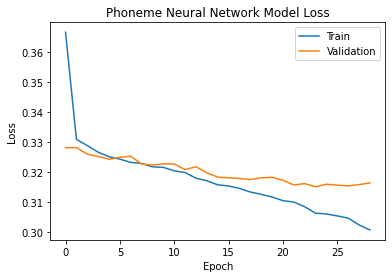

In [ ]:
#Plot training and validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Phoneme Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
#Predict on the validation set
valid_predictions = phoneme_NNmodel.predict(X_valid_arr)

In [ ]:
#Define Averaged Perceptron model

class Classifier(object):
    """
    The Classifier class is the base class for all of the Perceptron-based
    algorithms. Your class should override the "process_example" and
    "predict_single" functions. Further, the averaged models should
    override the "finalize" method, where the final parameter values
    should be calculated. 
    """
    
    #Iterations is member variable of class
    ITERATIONS = 10
    
    def train(self, X, y):
        for iteration in range(self.ITERATIONS):
            for x_i, y_i in zip(X, y):
                self.process_example(x_i, y_i)
        self.finalize()

    def process_example(self, x, y):
        """
        Makes a prediction using the current parameter values for
        the features x and potentially updates the parameters based
        on the gradient. Note "x" is a dictionary which maps from the feature
        name to the feature value and y is either 1 or -1.
        """
        raise NotImplementedError

    def finalize(self):
        """Calculates the final parameter values for the averaged models."""
        pass

    def predict(self, X):
        """
        Predicts labels for all of the input examples. You should not need
        to override this method.
        """
        return [self.predict_single(x) for x in X]

    def predict_single(self, x):
        """
        Predicts a label, 1 or -1, for the input example. "x" is a dictionary
        which maps from the feature name to the feature value.
        """
        raise NotImplementedError

class AveragedPerceptron(Classifier):
    def __init__(self, features):
        self.eta = 1
        
        #Current weight parameters and theta
        self.w = 0.0
        self.theta = 0
        
        #Vectors to hold all previous parameters and thetas summed, initialize as 0s
        self.sumw = 0.0
        self.sumtheta = 0
        
        #Initialize counter for number of examples looped through
        self.counter = 1
        
    def process_example(self, x, y):
        #Get either y_pred = -1 (if score leq 0) or = 1 (if score > 0)
        y_pred = self.predict_single(x)
        #If make a mistake (y != y_pred)
        if y != y_pred:
            #Loop through all features in example x
            #Update w normally
            self.w += self.eta * y * x
            #Update the summed parameters, multiplying by number of examples seen
            self.sumw += self.counter*self.eta*y*x
            #Update theta normally
            self.theta += self.eta * y
            #Update summed theta, multiplying by number of examples seen
            self.sumtheta += self.counter*self.eta*y
        #Increase counter (doesn't matter if error was made)
        self.counter += 1

    #Predict either -1 or 1 label on example x
    def predict_single(self, x):
        score = 0
        #Loop through all features in example x
        #Calculate dot product - multiply weight for that feature times value of feature in x
        score += self.w * x
        #Add theta to score
        score += self.theta
        #If the score is less than or equal to 0, return y_pred = -1
        if score <= 0:
            return -1
        #else return positive 1
        return 1
      
    #Returns final parameter values for averaged model
    def finalize(self):
        #Loop through all parameters in w
        self.w -= (1/self.counter)*self.sumw
        #Update final theta by subtracting sumtheta/counter
        self.theta -= (1/self.counter)*self.sumtheta

In [ ]:
#Make predictions on test data
X_test_arr = np.asarray(X_test)
test_predictions = phoneme_NNmodel.predict(X_test_arr)

In [ ]:
#One-hot encode validation labels
y_valid_phonemes_arr = one_hot_encode_phonemes(y_valid_phonemes_arr, all_phonemes)
y_valid_phonemes_arr = np.asarray(y_valid_phonemes_arr)

In [ ]:
features = [str(i) for i in range(1)]
test_predictions_thresholded = test_predictions.copy()
#Run each phoneme through averaged Perceptron using validation as training data since phoneme content is known
for counter, j in enumerate(valid_predictions[0]):
    #Get data for just one phoneme
    X = valid_predictions[:, counter]
    y = y_valid_phonemes_arr[:, counter]
    #Change all 0s to -1s for averaged Perceptron model
    y[y==0] = -1
    test = test_predictions[:, counter]
    avgperceptronClass = AveragedPerceptron(features)
    #Train averaged Perceptron on validation data
    avgperceptronClass.train(X, y)
    #Predict on test data (outputted from FF-neural network)
    avgperceptron_pred = avgperceptronClass.predict(test)
    test_predictions_thresholded[:, counter] = avgperceptron_pred
    #Change all -1 back to 0 for one-hot-encoding
    test_predictions_thresholded[:, counter][test_predictions_thresholded[:, counter] == -1] = 0

#Decode back to phonemes
test_predictions_unencoded = un_one_hot_encode_phonemes(test_predictions_thresholded, all_phonemes)

In [ ]:
#Remove any nationalities not present in test data 
test_nationalities_phonemes = {}

for key in nationalities_to_phonemes:
    if key in all_nationalities:
        test_nationalities_phonemes[key] = nationalities_to_phonemes[key]

del test_nationalities_phonemes['USA']
del test_nationalities_phonemes['Australia']
del test_nationalities_phonemes['Canada']
del test_nationalities_phonemes['UK']
del test_nationalities_phonemes['New Zealand']

In [ ]:
def make_predictions_overlap(nationalities_to_phonemes, y_phonemes):
    '''
    Function: Determine most likely nationality by maximizing Jaccard Index between predicted phonemes and 
    phonemes associated with each nationality
    Inputs: 
        - nationalities_to_phonemes: a mapping from nationalities to a set of associated phonemes
        - y_phonemes: list of predicted phonemes, each instance in list is a set of phonemes
    Outputs:
        - preds: list of most likely nationality for each instance 
        - all_preds - list of dictionaries containing Jaccard Index scores for each nationality for each index 
    '''
    preds = []
    all_preds = []
    for instance in y_phonemes:
        nationality_overlap = {}
        num_phonemes_in_instance = len(instance)
        for nationality in nationalities_to_phonemes:
            phoneme_overlap_count = 0
            num_phonemes_for_nationality = len(nationalities_to_phonemes[nationality])
            overlap = len(instance.intersection(nationalities_to_phonemes[nationality]))
            jaccard_index = overlap/(num_phonemes_in_instance+num_phonemes_for_nationality-overlap)
            nationality_overlap[nationality] = jaccard_index
        top_guess = max(nationality_overlap, key=nationality_overlap.get)
        preds.append(top_guess) 
        all_preds.append(nationality_overlap)
    return preds, all_preds

In [ ]:
#Predict nationalities based on phoneme content
y_test_nationalities_pred, confs = make_predictions_overlap(test_nationalities_phonemes, test_predictions_unencoded)

In [ ]:
def determine_accuracy_by_nationality(y_test_nationalities_list, y_test_nationalities_pred):
    '''
    Function: Determine accuracy in predicting nationality for each nationality
    Inputs: 
        - y_test_nationalities_list: list of true nationalities
        - y_test_nationalities_pred: list of predicted nationalities
    Outputs:
        - acc_per_nationality_dict: dictionary of accuracy per nationality, keys are nationalities
    '''    
    correct_count_per_nationality_dict = {}
    tot_count_per_nationality_dict = {}

    for nationality in y_test_nationalities_list:
        correct_count_per_nationality_dict[nationality] = 0
        tot_count_per_nationality_dict[nationality] = 0

    for i in range(len(y_test_nationalities_list)):
        tot_count_per_nationality_dict[y_test_nationalities_list[i]] += 1
        if y_test_nationalities_list[i] == y_test_nationalities_pred[i]:
            correct_count_per_nationality_dict[y_test_nationalities_list[i]] += 1 
    acc_per_nationality_dict = {}
    for nationality in tot_count_per_nationality_dict.keys():
        acc_per_nationality_dict[nationality] = \
        correct_count_per_nationality_dict[nationality]/tot_count_per_nationality_dict[nationality]

    return acc_per_nationality_dict

# Find accuracy per nationality on test set 
determine_accuracy_by_nationality(y_test_nationalities, y_test_nationalities_pred)

In [ ]:
#Get overall accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test_nationalities, y_test_nationalities_pred)